In [13]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from pathlib import Path

# Path style access for pandas
!pip install pandas-path
from pandas_path import path

import rasterio

import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import jaccard_score

In [10]:
def numpy_mask(image_path):
    with rasterio.open(image_path) as img:
        metadata = img.meta
        bounds = img.bounds
        data = img.read(1)  # read a single band

    with rasterio.open(image_path) as img:
        return img.read(1, masked=True)

# Get the metadata dataframe

In [28]:
# This is where our downloaded images and metadata live locally
DATA_PATH = Path.cwd().parent / "runtime" / "data" / "train_features"
train_metadata = pd.read_csv(
    DATA_PATH / "flood-training-metadata.csv", parse_dates=["scene_start"]
)

train_metadata = train_metadata.groupby("chip_id")
train_metadata

In [ ]:

PRED_PATH = Path.cwd().parent / "test submission" / "codeexecution"
train_metadata["pred_path"] = (
    str(PRED_PATH / "submission")
    / train_metadata.chip_id.path.with_suffix(".tif").path
)

train_metadata["label_path"] = (
    str(DATA_PATH / "train_labels")
    / train_metadata.chip_id.path.with_suffix(".tif").path
)

In [25]:
train_metadata

,image_id,chip_id,flood_id,polarization,location,scene_start,pred_path,label_path
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...
3,awc01_vv,awc01,awc,vv,Bolivia,2018-02-15,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...
4,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...
...,...,...,...,...,...,...,...,...
1079,wvy29_vv,wvy29,wvy,vv,UK,2019-02-15,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...
1080,wvy30_vh,wvy30,wvy,vh,UK,2019-02-15,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...
1081,wvy30_vv,wvy30,wvy,vv,UK,2019-02-15,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...
1082,wvy31_vh,wvy31,wvy,vh,UK,2019-02-15,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...


In [20]:
def get_score(pred_path, label_path):
    pred = numpy_mask(pred_path)
    label = numpy_mask(label_path)
    return jaccard_score(pred, label)

In [22]:
# print score
result = [get_score(x, y) for x, y in zip(train_metadata['pred_path'], train_metadata['label_path'])]
result

RasterioIOError: C:/Users/maxlu/Desktop/Machine_Learning/PROJECTS/DRIVENDATA/floodwater_competition/test submission/codeexecution/submission/awc00_vh.tif: No such file or directory

C:\Users\maxlu\Anaconda3\envs\env_floodwater\lib\site-packages\rasterio\__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


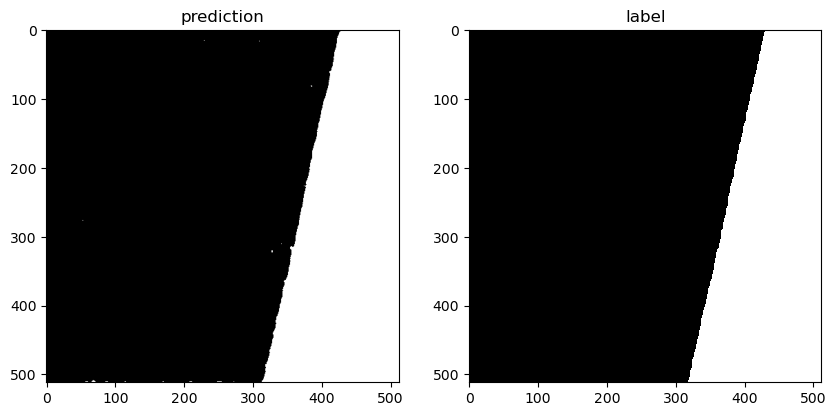

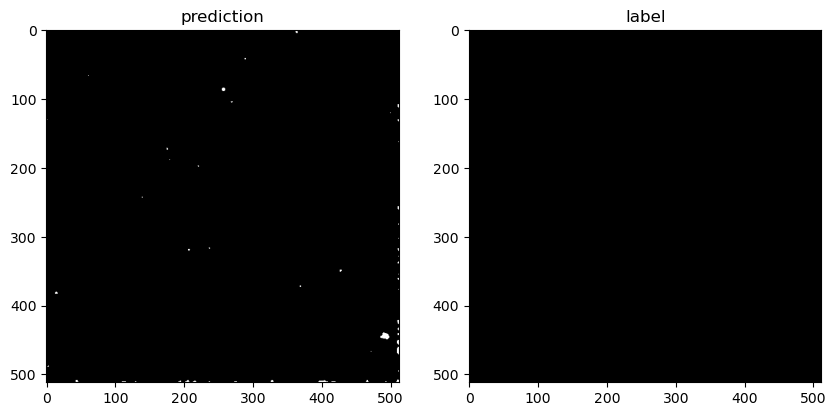

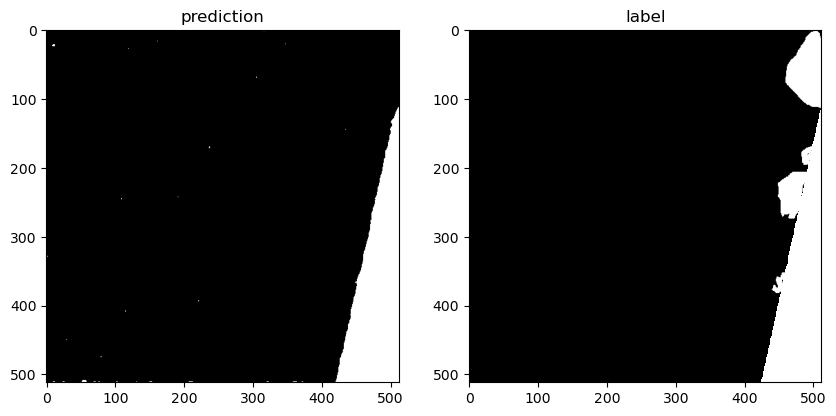

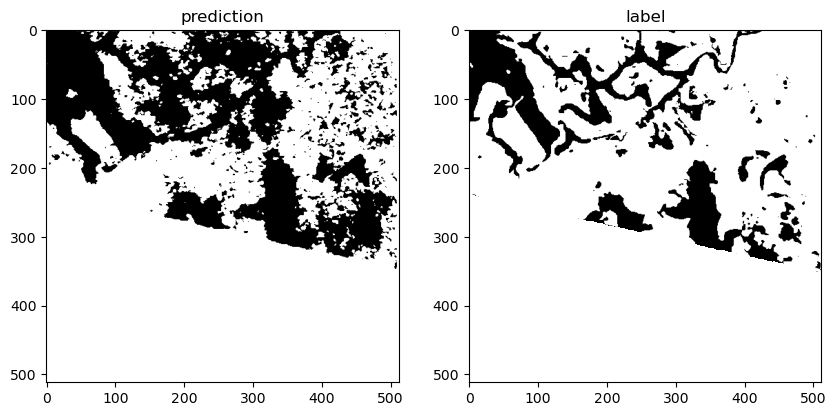

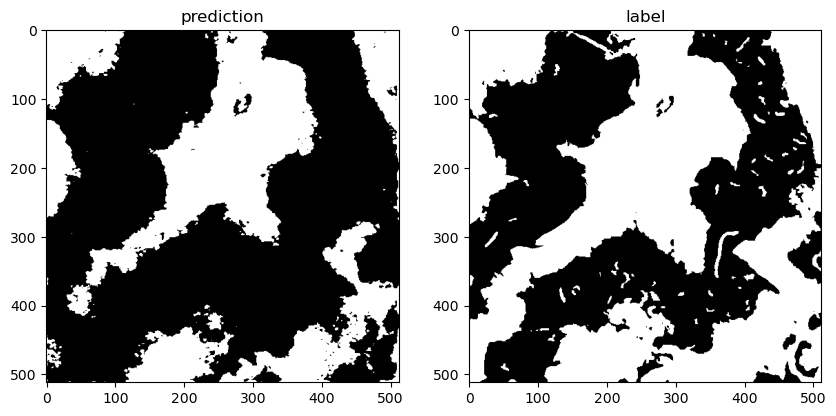

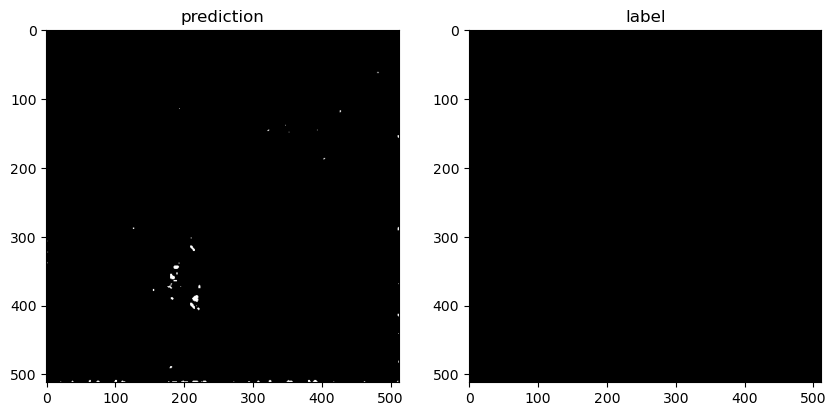

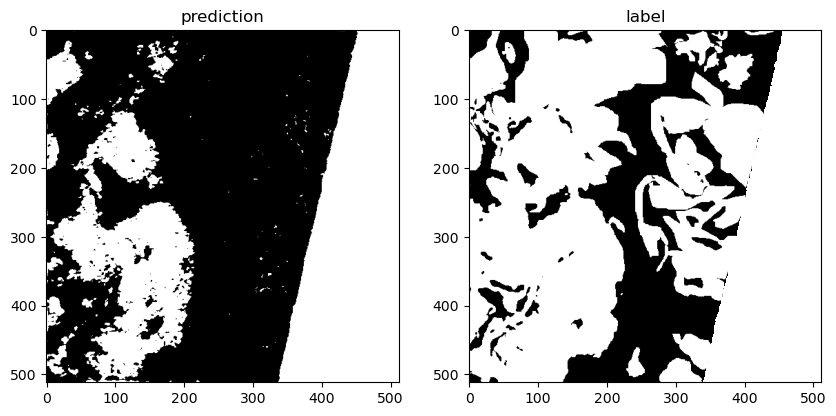

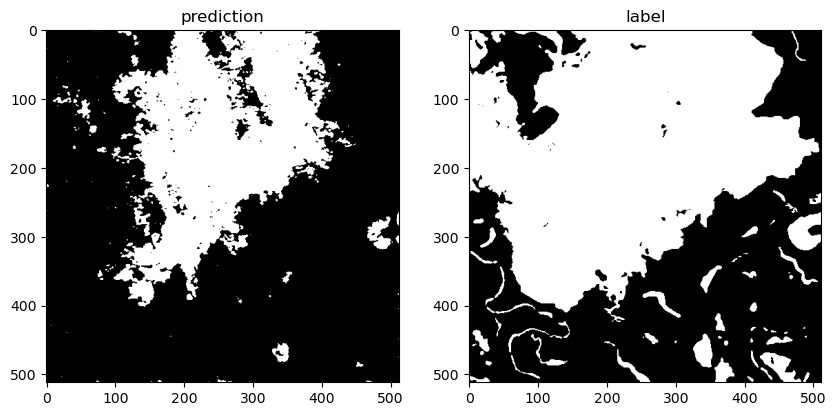

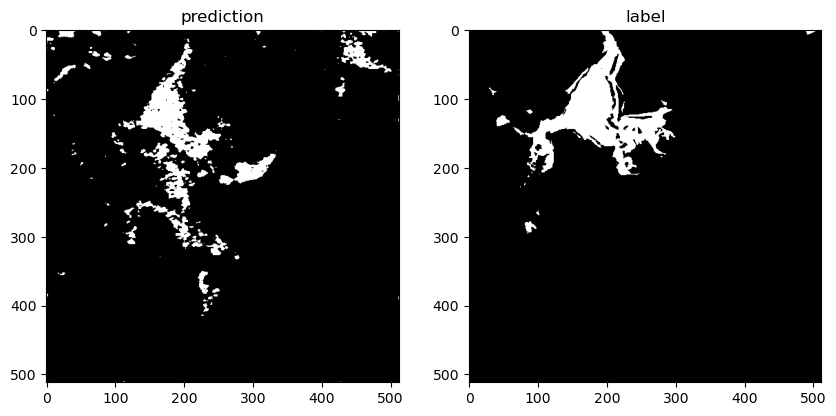

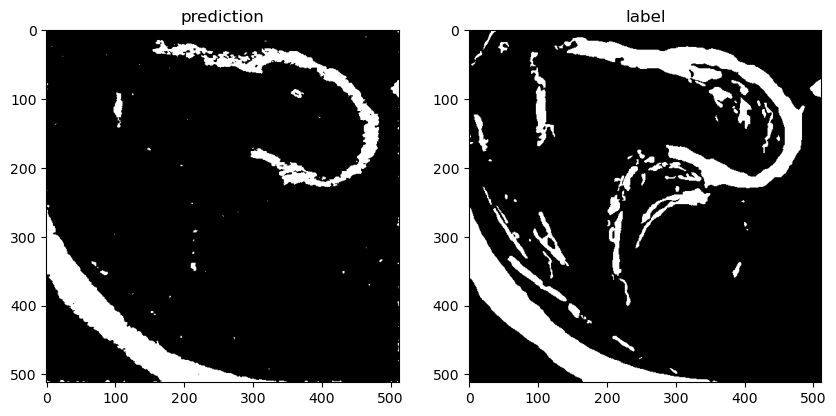

In [11]:
mypath = os.path.join(os.path.dirname(os.getcwd()), 'test submission', 'codeexecution', 'submission')
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]

label_path = os.path.join(os.path.dirname(os.getcwd()), 'runtime', 'data', 'train_features', 'train_labels')

for i in range(10):
    pred = numpy_mask(os.path.join(mypath, files[i]))
    f, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(pred, "gray")
    ax[0].set_title("prediction")
    ax[1].imshow(numpy_mask(os.path.join(label_path, files[i])), "gray")
    ax[1].set_title("label")
    plt.show()